In [1]:
!pip install tensorflow==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 96.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.3.2
    Uninstalling ml-dtypes-0.3.2:
      Successfully uninstalled ml-dtypes-0.3.2
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      

In [2]:
import math
import os
import cv2
import time
import random
import numpy as np

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import preprocess_input

import seaborn as sns
import matplotlib.pyplot as plt
tf.__version__, np.__version__

2024-11-29 05:56:06.348838: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-29 05:56:06.348899: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-29 05:56:06.350620: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


('2.15.0', '1.26.4')

In [3]:
from tensorflow.keras.applications import Xception
input_shape = (150, 150, 3)
pretrained_model = Xception(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg',
    )

83683744/83683744 [==============================] - 0s 0us/step


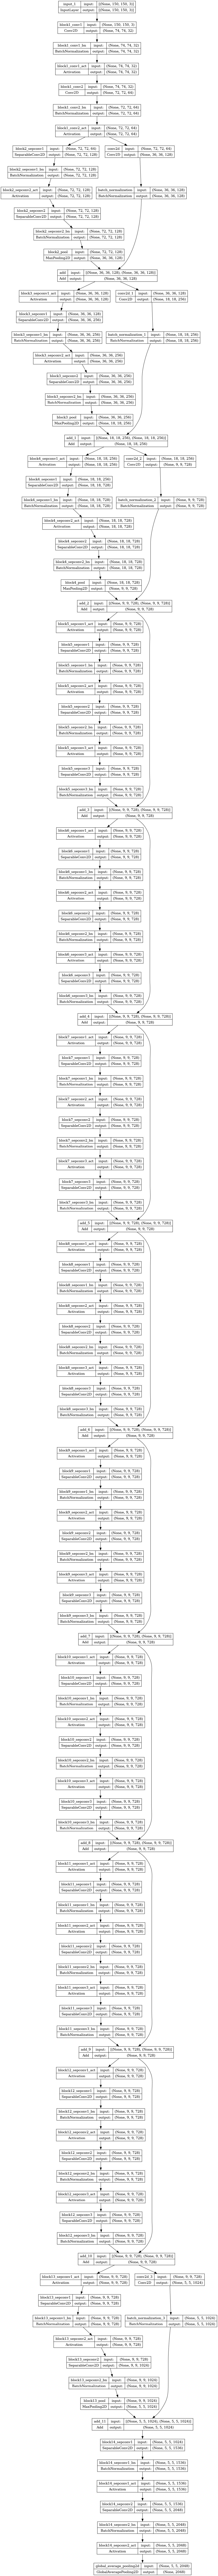

In [4]:

from tensorflow.keras.utils import plot_model
plot_model(pretrained_model, show_shapes=True, show_layer_names=True)

In [5]:
random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)

ROOT = "../input/face-recognition-dataset/Extracted Faces/Extracted Faces"

def read_image(index):
    path = os.path.join(ROOT, index[0], index[1])
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [6]:
def split_dataset(directory, split=0.9):
    folders = os.listdir(directory)
    num_train = int(len(folders)*split)
    
    random.shuffle(folders)
    
    train_list, test_list = {}, {}
    
    # Creating Train-list
    for folder in folders[:num_train]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        train_list[folder] = num_files
    
    # Creating Test-list
    for folder in folders[num_train:]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        test_list[folder] = num_files  
    
    return train_list, test_list

train_list, test_list = split_dataset(ROOT, split=0.9)
print("Length of training list:", len(train_list))
print("Length of testing list :", len(test_list))

# train_list, test list contains the folder names along with the number of files in the folder.
print("\nTest List:", test_list)

Length of training list: 1191
Length of testing list : 133

Test List: {'323': 2, '1': 2, '1479': 2, '1307': 4, '1588': 46, '1447': 4, '621': 7, '1074': 4, '649': 12, '1487': 4, '616': 13, '1045': 2, '1674': 2, '591': 11, '564': 2, '925': 2, '257': 3, '66': 3, '211': 4, '226': 7, '970': 2, '911': 3, '620': 4, '342': 2, '1531': 7, '1544': 2, '1486': 6, '389': 3, '460': 3, '435': 7, '155': 2, '858': 7, '1110': 3, '124': 2, '332': 2, '881': 3, '983': 2, '912': 3, '1184': 3, '586': 2, '985': 2, '959': 2, '803': 4, '1036': 2, '775': 2, '630': 2, '1506': 2, '707': 2, '1583': 2, '768': 3, '469': 4, '237': 3, '251': 7, '848': 2, '1527': 2, '1242': 2, '1256': 8, '418': 3, '1511': 2, '1002': 3, '532': 2, '268': 3, '741': 2, '824': 14, '234': 5, '197': 2, '1587': 3, '316': 4, '1370': 3, '184': 3, '205': 12, '940': 2, '492': 2, '625': 12, '294': 2, '1296': 2, '1147': 2, '361': 3, '311': 2, '631': 15, '32': 3, '1222': 2, '91': 3, '74': 7, '695': 3, '1189': 29, '1676': 9, '1677': 3, '876': 10, '747'

In [7]:
def create_triplets(directory, folder_list, max_files=10):
    triplets = []
    folders = list(folder_list.keys())
    
    for folder in folders:
        path = os.path.join(directory, folder)
        files = list(os.listdir(path))[:max_files]
        num_files = len(files)
        
        for i in range(num_files-1):
            for j in range(i+1, num_files):
                anchor = (folder, f"{i}.jpg")
                positive = (folder, f"{j}.jpg")

                neg_folder = folder
                while neg_folder == folder:
                    neg_folder = random.choice(folders)
                neg_file = random.randint(0, folder_list[neg_folder]-1)
                negative = (neg_folder, f"{neg_file}.jpg")

                triplets.append((anchor, positive, negative))
            
    random.shuffle(triplets)
    return triplets

In [8]:
train_triplet = create_triplets(ROOT, train_list)
test_triplet  = create_triplets(ROOT, test_list)

print("Number of training triplets:", len(train_triplet))
print("Number of testing triplets :", len(test_triplet))

print("\nExamples of triplets:")
for i in range(5):
    print(train_triplet[i])

Number of training triplets: 9996
Number of testing triplets : 1235

Examples of triplets:
(('1308', '6.jpg'), ('1308', '7.jpg'), ('736', '0.jpg'))
(('422', '1.jpg'), ('422', '2.jpg'), ('1616', '12.jpg'))
(('1410', '3.jpg'), ('1410', '5.jpg'), ('1400', '1.jpg'))
(('1597', '3.jpg'), ('1597', '4.jpg'), ('495', '1.jpg'))
(('1580', '3.jpg'), ('1580', '4.jpg'), ('1072', '0.jpg'))


In [9]:
def get_batch(triplet_list, batch_size=256, preprocess=True):
    batch_steps = math.ceil(len(triplet_list)//batch_size)
    
    for i in range(batch_steps):
        anchor   = []
        positive = []
        negative = []
        
        j = i*batch_size
        while j<(i+1)*batch_size and j<len(triplet_list):
            a, p, n = triplet_list[j]
            anchor.append(read_image(a))
            positive.append(read_image(p))
            negative.append(read_image(n))
            j+=1
            
        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)
        
        if preprocess:
            anchor = preprocess_input(anchor)
            positive = preprocess_input(positive)
            negative = preprocess_input(negative)
        
        yield ([anchor, positive, negative])

In [10]:
# num_plots = 5

# f, axes = plt.subplots(num_plots, 3, figsize=(15, 20))

# for ax_row in axes:
#     for ax in ax_row:
#         ax.set_axis_off()  # Вимкнути показ осей на графіку

# for x in get_batch(train_triplet, batch_size=num_plots, preprocess=False):
#     a,p,n = x
#     for i in range(num_plots):
#         axes[i, 0].imshow(a[i])
#         axes[i, 1].imshow(p[i])
#         axes[i, 2].imshow(n[i])
#         i+=1
#     break

In [11]:
from tensorflow.keras import backend, layers, metrics

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [12]:
def get_encoder(input_shape):
    x, y, ch = input_shape
    """ Returns the image encoding model """

    
    pretrained_model = Xception(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg',
    )
    
    for i in range(len(pretrained_model.layers)):#-27
        pretrained_model.layers[i].trainable = False
    encode_model = Sequential([
        pretrained_model,
                # Додаткові Dense шари для витягання характеристик
        layers.Dense(512, activation='relu', kernel_regularizer='l2'),  # L2 регуляризація для уникнення перенавчання
        layers.BatchNormalization(),  # Стабілізація навчання
        layers.Dropout(0.5),  # Dropout для регуляризації

        layers.Dense(256, activation='relu', kernel_regularizer='l2'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        # L2 нормалізація для одиничної довжини векторів
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ], name="Encode_Model")
    #     #layers.Input(shape=input_shape),
    #     #layers.Conv2D(256, (3, 3), activation='relu'),
    #     # layers.MaxPooling2D(),
    #     # layers.Conv2D(128, (3, 3), activation='relu'),
    #     # layers.MaxPooling2D(),
    #     # layers.Conv2D(64, (3, 3), activation='relu'),
    #     # layers.MaxPooling2D(),
    #     # layers.Flatten(),

   
    #     layers.Dense(512, activation='relu'),
    #     layers.BatchNormalization(),
    #     layers.Dense(256, activation="relu"),
    #     layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    # ], name="Encode_Model")
    return encode_model
    

In [13]:
class DistanceLayer(layers.Layer):
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)
    

def get_siamese_network(input_shape = (128, 128, 3)):
    encoder = get_encoder(input_shape)
    
    # Input Layers for the images
    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")
    
    ## Generate the encodings (feature vectors) for the images
    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    distances = DistanceLayer()(
        encoder(anchor_input),
        encoder(positive_input),
        encoder(negative_input)
    )
    
    # Creating the Model
    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )
    return siamese_network

get_siamese_network = get_siamese_network()
get_siamese_network.summary()

Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Anchor_Input (InputLayer)   [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Positive_Input (InputLayer  [(None, 128, 128, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 Negative_Input (InputLayer  [(None, 128, 128, 3)]        0         []                            
 )                                                                                                
                                                                                    

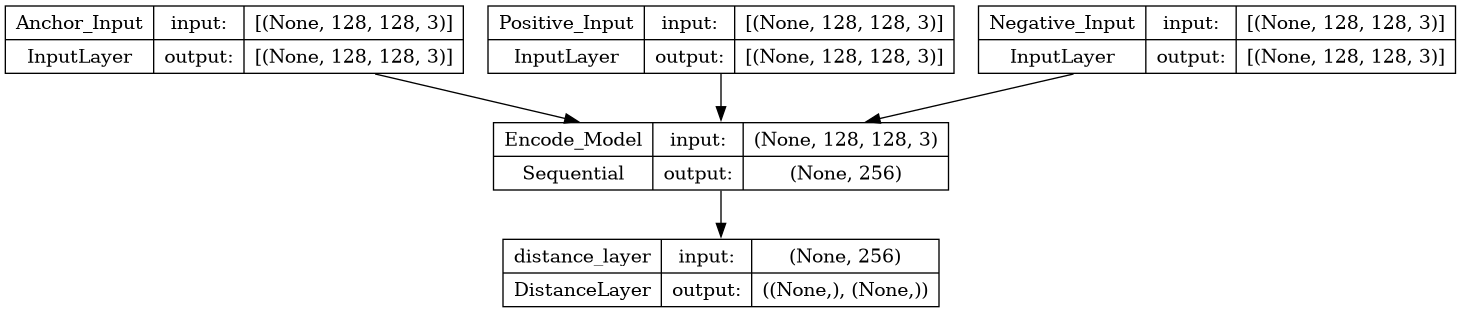

In [14]:
plot_model(get_siamese_network, show_shapes=True, show_layer_names=True)

In [15]:
class SiameseModel(Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()
        
        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")
        self.test_loss_tracker = metrics.Mean(name="test loss")
    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):

        # GradientTape get the gradients when we compute loss, and uses them to update the weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
            
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):

        loss = self._compute_loss(data)
        
        self.test_loss_tracker.update_state(loss)
        return {"test_loss": self.test_loss_tracker.result()}

    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker, self.test_loss_tracker]

In [16]:
def test_on_triplets(data_triplet, batch_size = 256, threshold=1.2):
    pos_scores, neg_scores = [], []

    for data in get_batch(data_triplet, batch_size=batch_size):
        prediction = siamese_model.predict(data)
        pos_scores += list(prediction[0])
        neg_scores += list(prediction[1])
    
    ap_mean = np.mean(pos_scores)
    an_mean = np.mean(neg_scores)
    ap_stds = np.std(pos_scores)
    an_stds = np.std(neg_scores)
    
    true_positives = np.sum(np.array(pos_scores) < threshold)  # Правильно визначені позитивні пари
    true_negatives = np.sum(np.array(neg_scores) >= threshold)  # Правильно визначені негативні пари
    total_samples = len(pos_scores) + len(neg_scores)

    accuracy = (true_positives + true_negatives) / total_samples
    #print(f"Accuracy on test = {accuracy:.5f}")
    return (accuracy, ap_mean, an_mean, ap_stds, an_stds)

In [17]:
siamese_model = SiameseModel(get_siamese_network)

optimizer = Adam(learning_rate=1e-3, epsilon=1e-01)
siamese_model.compile(optimizer=optimizer)


In [ ]:
import gc
import tensorflow as tf

save_all = False
epochs = 25
batch_size = 256

max_acc = 0
train_losses = []  # Список для збереження тренувальних втрат
test_losses = []   # Список для збереження тестувальних втрат
train_accuracy = []  # Список для тренувальної точності
test_accuracy = []   # Список для тестувальної точності
test_metrics = []
train_metrics = []
t_start = time.time()
for epoch in range(1, epochs + 1):
    t = time.time()
    
    # Тренування моделі
    epoch_loss = []
    epoch_accuracy = []  # Для обчислення середньої точності за епоху
    
    for data in get_batch(train_triplet, batch_size=batch_size):
        loss = siamese_model.train_on_batch(data)
        #print(type(data)[0])
        epoch_loss.append(loss)
    #print(epoch_loss)
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    train_losses.append(epoch_loss)
    test_loss = []
    for data in get_batch(test_triplet, batch_size=batch_size):
        #print(type(data)[0])
        result = siamese_model.test_step(data)
        loss = result["test_loss"].numpy()  # Отримуємо значення тензора і конвертуємо в Python float
        test_loss.append(loss)
        
    test_loss = sum(test_loss) / len(test_loss)
    test_losses.append(test_loss)
    print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time()-t)} sec)")
    print(f"Loss on train    = {epoch_loss:.5f}")
    print(f"Loss on test    = {test_loss:.5f}")
      
    # Testing the model on test data
    metric = test_on_triplets(test_triplet, batch_size=batch_size)
    test_metrics.append(metric)
    accuracy = metric[0]
    test_accuracy.append(accuracy)
    
    # Testing the model on train data
    train_metric = test_on_triplets(train_triplet, batch_size=batch_size*2)
    train_metrics.append(train_metric)
    tr_accuracy = train_metric[0]
    train_accuracy.append(tr_accuracy)
    
    print(f"Train Accuracy: ", tr_accuracy, "\t Test Accuracy: ", accuracy)

    if save_all or accuracy>=max_acc:
        siamese_model.save_weights("siamese_model")
        max_acc = accuracy


    # Після завершення кожної епохи
    gc.collect()
    tf.keras.backend.clear_session()
# Після завершення тренування
print("\nTraining Complete!")
print(f"Final Train Loss: {train_losses[-1]:.5f} \t Final Train Accuracy: {train_accuracy[-1]:.2%}")
print(f"Final Test Loss: {test_loss[-1]:.5f} \t Final Test Accuracy: {test_accuracy[-1]:.2%}")

    #accuracy = metric[0]
    
    # Saving the model weights
   

# Saving the model after all epochs run
siamese_model.save_weights("siamese_model-final")

I0000 00:00:1732859818.347659      92 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



EPOCH: 1 	 (Epoch done in 147 sec)
Loss on train    = 0.60294
Loss on test    = 0.52722
16/16 [==============================] - 2s 158ms/step
Train Accuracy:  0.7257401315789473 	 Test Accuracy:  0.71826171875

EPOCH: 2 	 (Epoch done in 110 sec)
Loss on train    = 0.47096
Loss on test    = 0.47979
16/16 [==============================] - 2s 154ms/step
Train Accuracy:  0.7757504111842105 	 Test Accuracy:  0.74462890625

EPOCH: 3 	 (Epoch done in 110 sec)
Loss on train    = 0.40728
Loss on test    = 0.47030
16/16 [==============================] - 2s 155ms/step
Train Accuracy:  0.787828947368421 	 Test Accuracy:  0.740234375

EPOCH: 4 	 (Epoch done in 117 sec)
Loss on train    = 0.36470
Loss on test    = 0.45245
16/16 [==============================] - 2s 150ms/step
Train Accuracy:  0.8010896381578947 	 Test Accuracy:  0.7216796875

EPOCH: 5 	 (Epoch done in 113 sec)
Loss on train    = 0.32380
Loss on test    = 0.43291
16/16 [==============================] - 2s 150ms/step
Train Accura

In [ ]:
def plot_metrics(train_loss, test_loss, train_accuracy, test_accuracy, metrics):
    # Extracting individual metrics from metrics
    #accuracy = metrics[:, 0]
    ap_mean  = metrics[:, 1]
    an_mean  = metrics[:, 2]
    ap_stds  = metrics[:, 3]
    an_stds  = metrics[:, 4]
    
    plt.figure(figsize=(15,5))
    
    
    plt.subplot(121)
    plt.plot(train_accuracy, 'b', label='Train Accuracy')
    plt.plot(test_accuracy, 'r', label='Test Accuracy')
    plt.title('Accuracy (Train vs Test)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Графік для втрат
    plt.subplot(122)
    plt.plot(train_losses, 'b', label='Train Loss')
    plt.plot(test_losses, 'r', label='Test Loss')
    plt.title('Loss (Train vs Test)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

    
    # Plotting the accuracy
    ap_75quartile = (ap_mean+ap_stds)
    an_75quartile = (an_mean-an_stds)
    plt.subplot(122)
    plt.plot(ap_75quartile, 'b', label='AP (Mean+SD)')
    plt.plot(an_75quartile, 'g', label='AN (Mean-SD)')
    plt.title('75th Quartile Comparision')
    plt.legend()

test_metrics = np.array(test_metrics)
plot_metrics(train_losses, test_losses, train_accuracy, test_accuracy, test_metrics)